In [1]:
# CSS formatting for the Notebook. Run to apply format
from IPython.core.display import HTML;      
HTML("""<link rel="stylesheet" href="./custom.css">""")

<div id=headerNotebook>
<h1 class=headtitle><b>Analyzing Neuroimaging Data with PySpark and Thunder</b><br/>2017 Edition</h1>
<div class=date>24/05/2017</div>
<div class=authors><b>Authors</b>     Ole Andreas Hansen |
                            Alberto Ibarrondo Luis</div>
                            </div>

Advances in imaging equipment and automation have led to an overabundance of data on the functioning of the brain. Technologies today can sample brain activity from a large number of neurons in a large region while organisms are actively behaving. For example, by simultaneously recording the electrical activity of every neuron of the mouse brain over an extended period of time, the amount of data generated will create completely new paradigms for biology, that will require the development of tools to extract value from such unprecedented amount of information.

In this Notebook, we use PySpark and the [Thunder project](https://github.com/thunder-project/thunder), which is developed on top of PySpark, for processing large amounts of time series data in general, and neuroimaging data in particular. We will use these tools for the task of understanding some of the structure of Zebrafish brains, which is a typical (and simple) example used in Neuroimaging. Using Thunder, we will cluster different regions of the brain (representing groups of neurons) to discover patterns of activity as the zebrafish behaves over time.

**Note**: Please, use the documentation for the [Thunder API](http://docs.thunder-project.org/) to learn the details of function calls!


# Goals

The main goals of this notebook are:

1. Learn about Thunder and how to use it
2. Revisit the K-Means algorithm and the method for choosing K
3. Learn alternative approaches to improve the results


# Steps
1. In section 1, we go though some background concepts that are used in this notebook.
2. Next, in section 2, we will get familiar with Thunder, its methods and its data types, by working on some simple tasks.
3. Finally, in section 3, we will build a model to cluster the neurons of a zebrafish based on their behavior. In this step, we will learn about how to use K-Means when the value of K is unknown. Finally, some tricks to improve the results are introduced.

# 1. Background concepts

In this section, we cover the terminology and the concepts that constitute the domain knowledge for this notebook.

As it should be well-known, a `pixel` is a combination of "**pic**ture **el**ement": digital images can be modeled as simple 2-dimensional (2D) matrices of intensity values, and each element in the matrix is a pixel. In color images, a pixel contains values of red, green, and blue channels. In a grayscale image, the three channels have the same value, such that each pixel is reduced to be a single value.

A single 2D image is not nearly enough to express 3D objects, which use a **voxel**, representing a value of the 3D image on a regular grid in a three-dimensional space.  A possible technique to work on 3D images is to acquire multiple 2D images of different slices (or `planes`, or `layers`) of a 3D object, and stack them one on top of each other (a z-stack). This ultimately produces a 3D matrix of intensity values, where each value represents a `volume element` or `voxel`.

![](https://upload.wikimedia.org/wikipedia/commons/b/b4/Voxelgitter.png)
<div style="text-align:center;">This z-stack image has 4 layers. A point is a voxel. It can be determined by the layer's index and the position in that layer.</div>

In the context of the Thunder package, we use term `image` for `3D-image` or `stack image`. Thunder uses `Image` type to  represent 3D-image. Each `Image` object is a collection of either 2D images or 3D volumes. In practice, it wraps an n-dimensional array, and supports either distributed operations via Spark or local operations via  numpy , with an identical API.

Stack-images can represent 3D objects, but it can be difficult to take the temporal relationship of the images into account. To do that, we need another data structure that shows the changes of voxels over time. In the Thunder package, the internal `Series` type can be used exactly for this purpose. Each `Series` is a 1D array such that each element is a value of the voxel at a timestamp.

The most common series data is time series data, in which case the index is time and each record is a different signal, like a channel or pixel.

We now have sufficient material to start playing with Thunder !!!

# 2. Let's play

Well, wait a second before we play... Remember, we're going to use Spark to perform some of the computations related to this Notebook. Now, when you spin a Zoe Notebook application (this comment is valid for students at Eurecom), you'll gain access to an individual, small Spark cluster that is dedicated to your Notebook. This cluster has two worker machines, each with 6 cores. As such, a good idea to obtain smooth performance and a balanced load on the workers, is to ```repartition``` your data (i.e., the RDDs you use to represent images or time series).

In this Notebook we **expect** students to take care of repartitioning, and such care will be compensated by bonus points.

## 2.1. Play with Image objects

### a. Loading image data

Both `images` and `series` can be loaded from a variety of data types and locations. You need to specify whether data should be loaded in 'local' mode, which is backed by a numpy array, or in 'spark' mode, which is backed by an RDD by using the optional argument `engine`. The argument `engine` can be either `None` for local use or a SparkContext for` distributed use with Spark.

```python
import thunder as td

# load data from tif images
data = td.images.fromtif('/path/to/tifs')

# load data from numpy-arrays
data = td.series.fromarray(somearray)
data_distributed = ts.series.fromarray(somearray, engine=sc)
```

We can load some example image data by:

In [2]:
import thunder as td
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# load some example image data
image_data = td.images.fromexample('fish', engine=sc)

# print the number of images
print(image_data.count())

20


### b. Inspecting image data

Shape of the data: (20, 2, 76, 87)
Shape of the data of the first image: (2, 76, 87)
Data of the first image: [[[26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 27 27 26]
  ..., 
  [26 26 26 ..., 27 27 26]
  [26 26 26 ..., 27 26 26]
  [25 25 25 ..., 26 26 26]]

 [[25 25 25 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  ..., 
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]]]


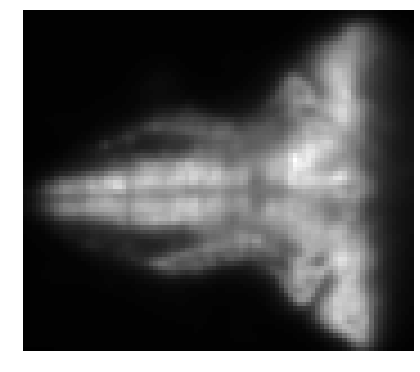

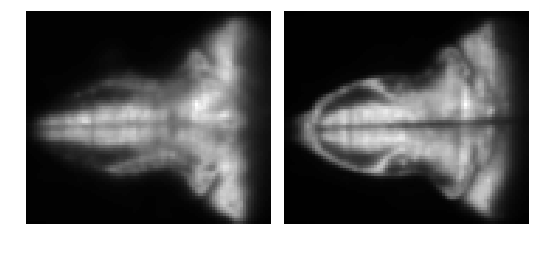

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# import two function to draw images easier
from showit import image as draw_image
from showit import tile as draw_tile

print("Shape of the data:", image_data.shape)

first_image = image_data.first() # get the values of Image object
# or first_image = image_data[0] # get the Image object

print("Shape of the data of the first image:", first_image.shape)

print("Data of the first image:", first_image)


# draw the first layer of the first image
draw_image(first_image[0])

# draw all layers of the first image
draw_tile(first_image)

# we can use index slices to take images
samples = image_data[0:6]



From the result above, the shape of the loaded data is (20, 2, 76, 87). It means we have total 20  3D images objects. Each image has 2 layers, each layer has size 76x87. 

Note that, although  data  is not itself an array (it can be a kind of RDD), we can index into it using bracket notation, and pass it as input to plotting methods that expect arrays. In these cases, the data will be automatically converted.

One of the advantages of working in Python is that we can easily visualize our data stored into Spark RDDs using the Matplotlib library. Function `draw_image` and `draw_tile` that take advantages of Matplotlib are examples.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 1

<div class="alert alert-info">  
a) Use the function `imgshow` from matplotlib to plot each layer of the first image in `image_data`.  

b) Discuss the choice of parameters you use for the method `imgshow`  

</div>

In [4]:
image_data.repartition(12)

Images
mode: spark
dtype: uint8
shape: (20, 2, 76, 87)

<div class="alert alert-warning">
<b>Comment: </b><br />
We're making use of SPARKs repartition. We have in total 12 cores to distribute the load on. 
</div>

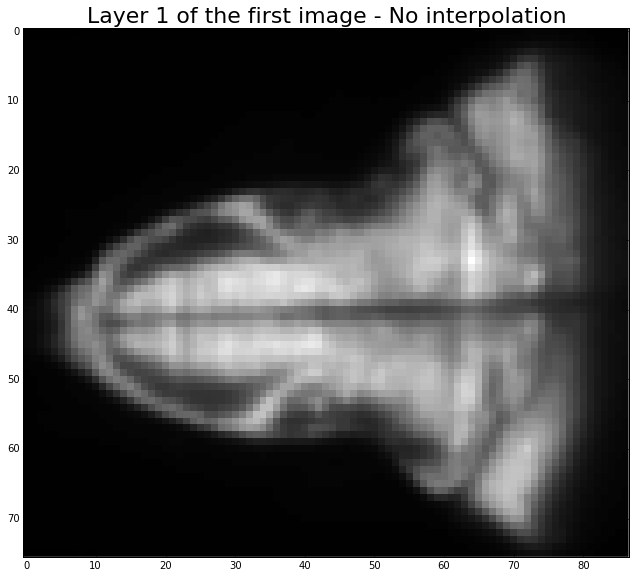

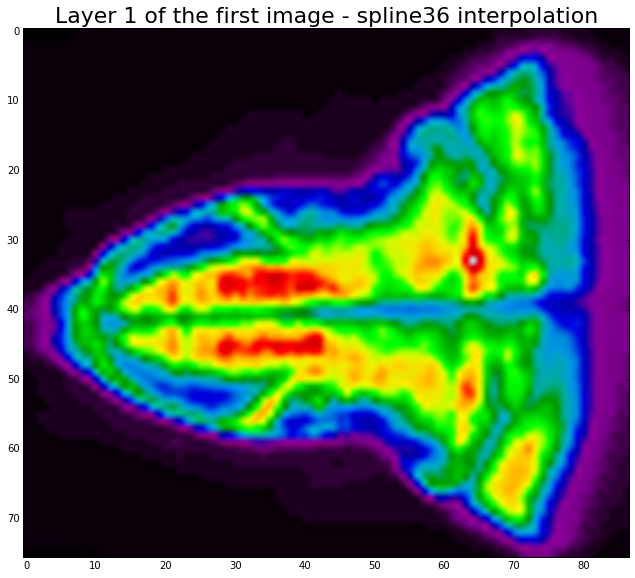

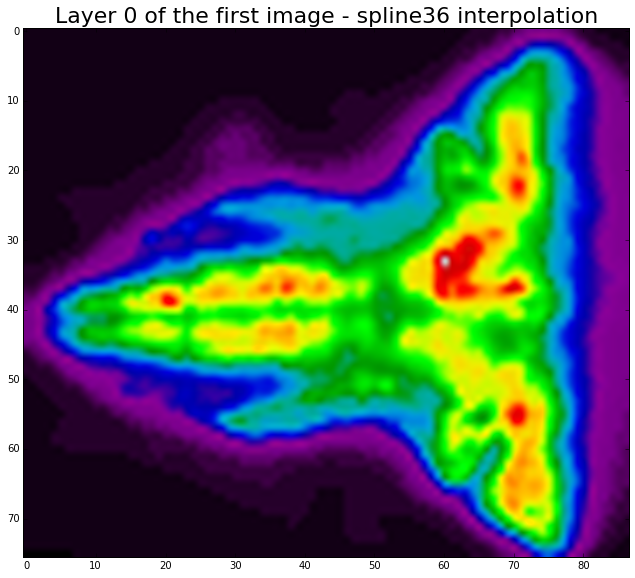

In [5]:
img = image_data.first() 
# or:
# img = image_data[1]

# show the first layer
plt.figure(figsize=[76/7,87/7])
plt.imshow(img[1], interpolation='None', aspect='equal', cmap='gray')
plt.title("Layer 1 of the first image - No interpolation", fontsize=22)
plt.show()

# show the second layer with interpolation. Options are:
#   'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning',
#   'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos'

plt.figure(figsize=[76/7,87/7])
plt.imshow(img[1], interpolation='spline36', aspect='equal', cmap='spectral')
plt.title("Layer 1 of the first image - spline36 interpolation", fontsize=22)
plt.show()

plt.figure(figsize=[76/7,87/7])
plt.imshow(img[0], interpolation='spline36', aspect='equal', cmap='spectral')
plt.title("Layer 0 of the first image - spline36 interpolation", fontsize=22)
plt.show()

<div class='alert alert-warning'>
<b>COMMENT:</b><br/>
<ul>
<li>**ASPECT**: If auto: keep proportions. If `equal`, and `extent` is None, changes the axes aspect ratio to
    match that of the image. If `extent` is not `None`, the axes
    aspect ratio is changed to match that of the extent. Clearly, the best approach is to keep the original image proportion -> **auto** (also resizing the image for correct visualization, keeping the aspect ratio of the original image and dividing it by a ratio value).</li>
<li> **INTERPOLATION**: There are a lot of options. We tried them all: _'none', 'nearest', 'bilinear', 'bicubic',
    'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser',
    'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc',
    'lanczos'_. 
Based on the theory comprised in [Sampling and interpolation
for biomedical imaging](http://bigwww.epfl.ch/tutorials/unser_isbi_06_part1.pdf) (they suggest b-splines), and corroborated by our own extensive tests, we select **spline36** since it allows for a generalization of the image (soften edges) without loosing much resolution (as it is the case with gaussian interpolation).
</li>
<li>

**COLOR PALETTE**: is based on the research from [Colorful brains: 14 years of display practice in functional neuroimaging](http://www.geo.uzh.ch/~sara/pubs/christen_etal_neuroimage_13.pdf).
`spectral` is the closest color pallete we found to the "Reserved for PET binding potential" option, which we chose since it's a PET (Positron Emission Tomography) techniqhe of neuroimaging. In order to compare the original gray-scaled version with our preferred visualization, we leave the first image in gray scale -> **spectral**</li>
</ul>
</div>

Then, we can perform operations that aggregate information across images.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Calculate the standard deviation across all images you have in `image_data` (that is, our dataset). To clarify, let's focus on an individual layer (say the first layer of each image). For every `voxel`, compute the standard deviation of its values across different images for the same layer. Visualize the standard deviation you obtain, for example concerning a single layer (as before, say the first layer).

</div>

<div class="label label-success">HINT 1</div> to avoid wasting time and energy, make sure you lookup for methods that could help answer the question from the Thunder documentation.  

<div class="label label-success">HINT 2</div> We can also use function `draw_image(<data>)` to plot an image in a simple way instead of using many statements with matplotlib as before.

<div class="label label-danger">NOTE</div> Comment the image you obtain. What does it mean to display the standard deviation across all images in a single layer?

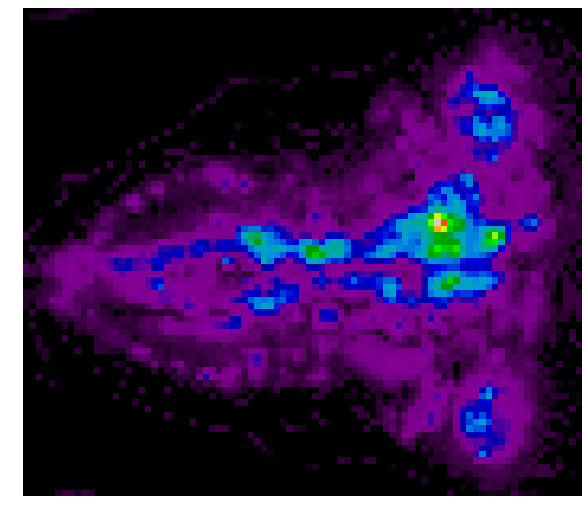

In [6]:
# calculate standard deviation of images
std_imgs = image_data.std()
draw_image(std_imgs.first()[1], cmap='spectral', size=10) # PROBLEM: No interpolation!

<div class='alert alert-warning'>
<b>COMMENT:</b><br/>
The hot areas of the standard deviation image represents where the brain activity changes most. Instead, in the normal images the red area represets the most active areas, so the areas with a low standard deviation but high activity are the most used over time, on the other hand the one that are red in both images are intermittently used.
<br/>
This time we lose interpolation since we are using a command that doesn't allow it. Nevertheless, resizing the image for better visualization is a must.</div>

### c. Selecting samples of image data

The Images API offers useful methods for working with large image data. For example, in some cases it is necessary to subsample each image, to make sure we can analyze it efficiently.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3

<div class="alert alert-info">  
The source code below subsamples image data with different ratios on different dimensions.   

a) Complete the source code to plot the first layer of the first image.   

b) What is the shape of `image_data` before and after subsampling?  

</div>

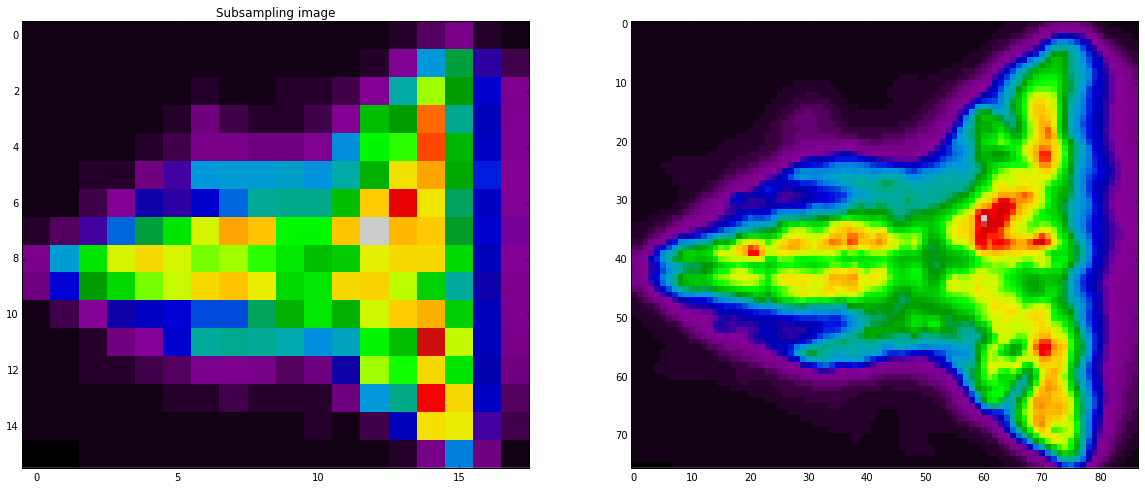

Before subsampling: (20, 2, 76, 87)
After subsampling: (20, 2, 16, 18)


In [7]:
subsampled = image_data.subsample((1, 5, 5))
# Stride to use in subsampling. If a single int is passed, each dimension of the image
# will be downsampled by this same factor. If a tuple is passed, it must have the same
# dimensionality of the image. The strides given in a passed tuple will be applied to
# each image dimension
f, axarr = plt.subplots(1,2, figsize=[20, 8])
axarr[0].imshow(subsampled.first()[0], interpolation='None', aspect='auto', cmap='spectral')
axarr[0].set_title("Subsampling image")
axarr[1].imshow(img[0], interpolation='None', aspect='auto', cmap='spectral')
plt.show()
print("Before subsampling:", image_data.shape)
print("After subsampling:", subsampled.shape)

<div class="alert alert-warning">
<b>COMMENT:</b><br />
The number of layers is the same as before subsampling, but the resolution has decreased from 76x87 to 16x18 (approximately a 5:1 ratio)
</div>

Note that `subsample` is an RDD operation, so it returns immediately. Indeed, we know that in Spark you must apply a RDD action to trigger the actual computation.

### d. Converting image data
We can also convert an RDD of images to a RDD of series by:

In [8]:
seriesRDD = image_data.toseries()
seriesRDD.cache()

Series
mode: spark
dtype: uint8
shape: (2, 76, 87, 20)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">
According to your understanding about `Series` objects which was introduced in section 1, what is the shape of `seriesRDD` and its elments ?  

Comment your results, don't just display numbers.
</div>

In [9]:
print('Shape of the image series:   ', seriesRDD.shape)
print('Shape of the original image: ', image_data.shape)


Shape of the image series:    (2, 76, 87, 20)
Shape of the original image:  (20, 2, 76, 87)


<div class="alert alert-warning">
<b>COMMENT:</b><br />

The seriesRDD encompasses 2 layers of 76x87 voxels (rows x cols) with the time axis set in the last dimension of the series. The differences between both objects are:

<table>
  <tr>
    <th>Dimension</th>
    <th>Series</th>
    <th>Original Image</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Layers(2)</td>
    <td>Time axis (x20)</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Height (76)</td>
    <td>Layers(2)</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Width (87)</td>
    <td>Height (76)</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Time axis (x20)</td>
    <td>Width (87)</td>
  </tr>
</table>
</div>

For a large data set that will be analyzed repeatedly as a `Series`, it will ultimately be faster and more convienient to save `Images` data to a collection of flat binary files on a distributed file system, which can in turn be read back in directly as a `Series`, rather than repeatedly converting the images to a `Series` object. This can be performed either through a ThunderContext method, `convertImagesToSeries`, or directly on an Images object, as done below:

In [9]:
# image_data.toseries().tobinary('directory', overwrite=True)
#ts = td.series.frombinary('directory', engine=sc)

We will study about `Series` object in the next section.

## 2.2. Play with Serises objects

### a. Loading Series data

In this section, we use a sample data to explore `Series` objects.

In [10]:
# series_data = td.series.fromexample('fish', engine=sc)
# series_data = td.series.frombinary(path='s3n://thunder-sample-data/series/fish', engine=sc)
series_data = image_data.toseries()

### b. Inspecting Series data

`Series_data` is a distributed collection of key-value records, each containing a coordinate identifier and the time series of a single `voxel`. We can look at the first record by using `first()`. It’s a key-value pair, where the key is a tuple of `int` (representing a spatial coordinate within the imaging volume) and the value is an one-dimensional array.

In [11]:
first_series = series_data.first() # get the values of Series object
#first_series = series_data[0] # get a Series object

print("Shape of series:", series_data.shape)
print("The first series:", first_series)
print("Each element in series has", len(first_series), "values")

# print the 10th value of voxel (0,0,0)
# layer = 0
# coordinator = (0,0) in that layer
print("value 10th of voxel (0,0,0):", np.array(series_data[0,0,0,10]))

Shape of series: (2, 76, 87, 20)
The first series: [26 26 26 26 26 26 26 25 26 25 25 25 26 26 26 26 26 26 26 26]
Each element in series has 20 values
value 10th of voxel (0,0,0): 25


<div class="alert alert-warning">
<b>COMMENT:</b><br />
The shape of the series remains the same. And we can see that the first element in the series is only 26 and is probably the black spots on the top left of the image. Grayscale goes from 0 (black) to 255 (white). This can also be seen as noise in our image that we can safely remove since it does not have any impact for our use case.
</div>

The loaded series data is a multi-dimensional array. We can access the values of a voxel in time series by using a tuple as above. In our data, each voxel has 20 values corresponding to 20 states at 20 different times.

### c. Selecting Series data
Series objects have a 1D index, which can be used to subselect values.

In [12]:
print("Shape of index:", series_data.index.shape)
print("The first element of a subset", series_data.between(0,8).first())

Shape of index: (20,)
The first element of a subset [26 26 26 26 26 26 26 25]


Values can be selected based on their index:

In [13]:
print(series_data.select(lambda x: x > 3 and x < 8).index)
print(series_data.select(lambda x: x > 3 and x < 8).first())


[4, 5, 6, 7]
[26 26 26 25]


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 5
<div class="alert alert-info">

Plot the first 20 values of **all** series objects (that is the values of a voxel) in the series data. This means, on the same plot, you should visualize the values each voxel takes in the first 20 time intervals.

</div>

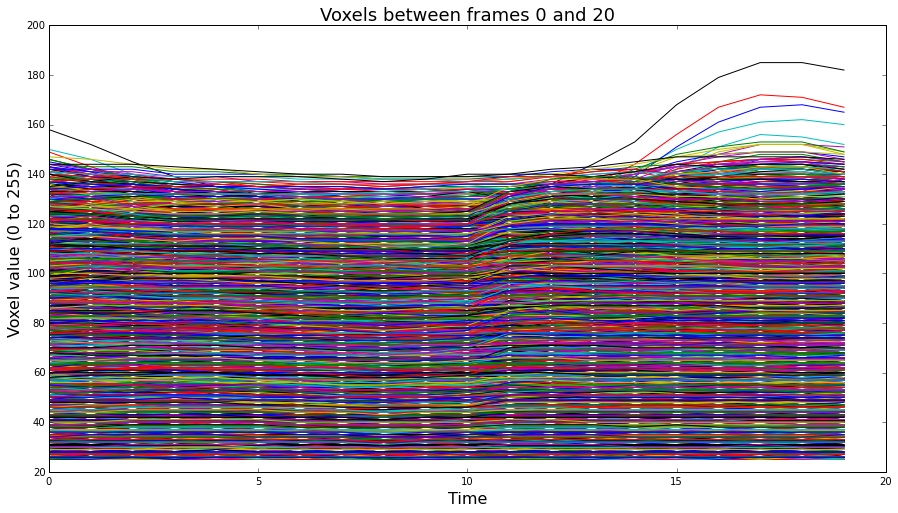

In [14]:
import numpy as np

# 20 first states
samples = series_data.between(0,20).tordd().values().collect()

plt.figure(figsize=(15,8))
plt.plot(np.array(samples).T)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Voxel value (0 to 255)', fontsize=16)
plt.title('Voxels between frames 0 and 20', fontsize=18)
plt.show()


<div class="alert alert-warning">
<b>COMMENT:</b><br/>
Around T12 (Time=12) we see that many voxels starts increasing their value for some reason. We can also point out 4 voxels that stand out from the rest (black, red, blue and tangerine?) both in the beginning and in the end. That's probably a very activated region. Se can also perceive a notable movement from T10 to T11 in many voxels, like a general activation of a wide region. 
</div>

Now, another objective we can have is to select specific series objects within the same series data. For example, we can select objects randomly by using function `sample`.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6

<div class="alert alert-info">

Let's plot a random subset of the data using the method `sample`.  

Complete the source code below to plot the first 20 values of 30 objects that are selected randomly among those that pass the condition on the standard deviation, using function `sample`.

</div>

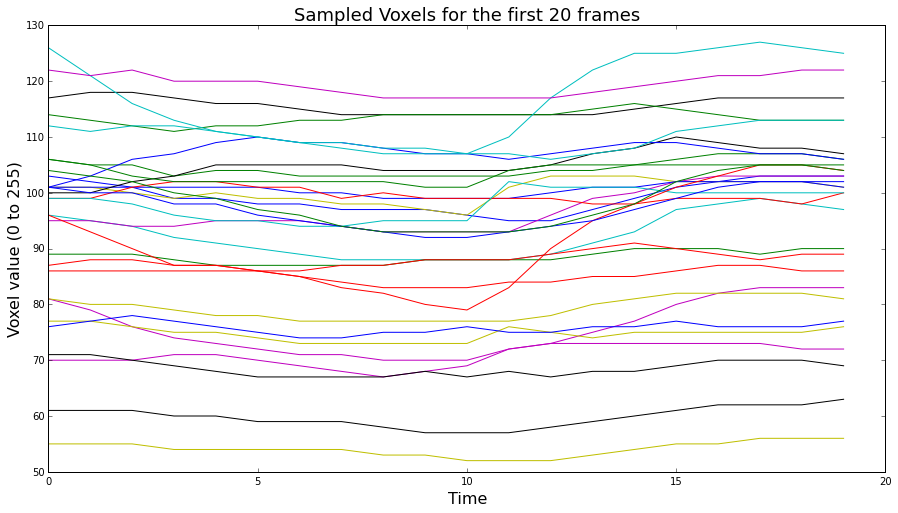

In [15]:

# select 30 objects randomly which have standard deviation > threshold
# Extract random subset of records, filtering on a summary statistic.
examples = series_data.filter(lambda x: x.std() > 1.0).sample(30)
# only plot first 20 states of each object
plt.figure(figsize=(15,8))
plt.plot(np.array(examples).T)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Voxel value (0 to 255)', fontsize=16)
plt.title('Sampled Voxels for the first 20 frames', fontsize=18)
plt.show()


### d. Preprocessing Series data
A `Series` objects has some methods which can be useful in an eventual preprocessing phase.

For example,`center` subtracts the mean, `normalize` subtracts and divides by a baseline (either the mean, or a percentile).

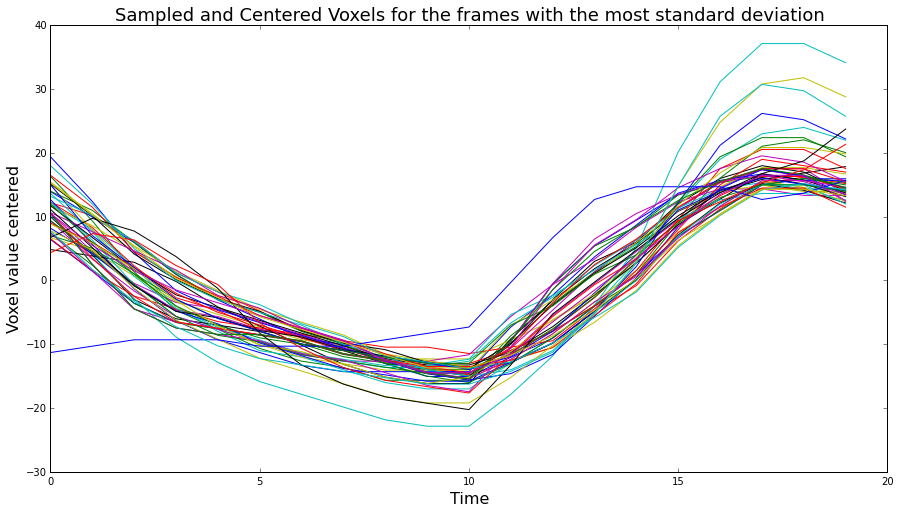

In [53]:
examples = series_data.center().filter(lambda x: x.std() >= 10).sample(50)
plt.figure(figsize=(15, 8))
plt.plot(np.array(examples).T)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Voxel value centered', fontsize=16)
plt.title('Sampled and Centered Voxels for the frames with the most standard deviation', fontsize=18)
plt.show()

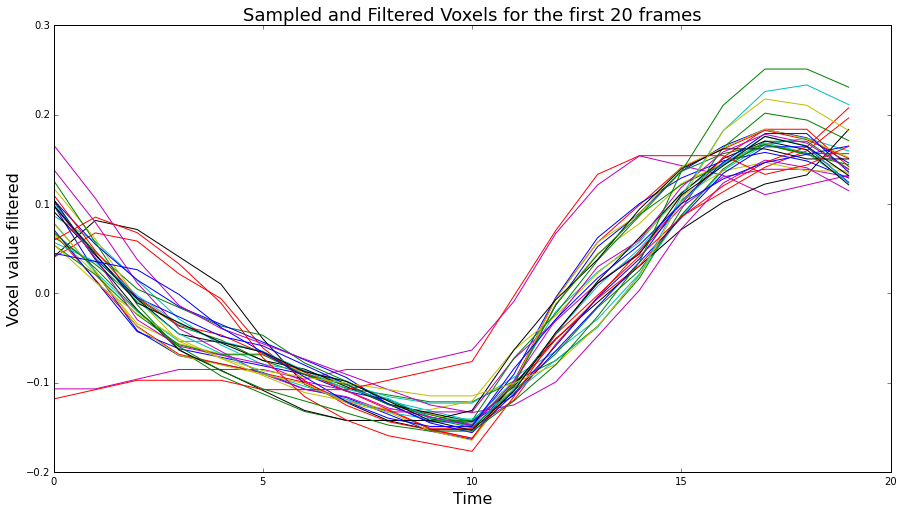

In [17]:
normalizedRDD = series_data.normalize(method='mean').filter(lambda x: x.std() >= 0.1).sample(50)
plt.figure(figsize=(15, 8))
plt.plot(np.array(normalizedRDD).T)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Voxel value filtered', fontsize=16)
plt.title('Sampled and Filtered Voxels for the first 20 frames', fontsize=18)
plt.show()

### e. Computing statistics about Series data
A `Series` can be summarized with statistics both within and across images. To summarize **across records** (the statistic of all voxels at each timestamp), we can do the following:

In [18]:
# Series to be plotted
seriesMax = series_data.normalize().max()
seriesMean = series_data.normalize().mean()
seriesMin = series_data.normalize().min()
x = np.arange(0.0, 20, 1)

In [19]:
seriesMax.count

<bound method Series.count of Series
mode: local
dtype: float64
shape: (1, 1, 1, 20)>

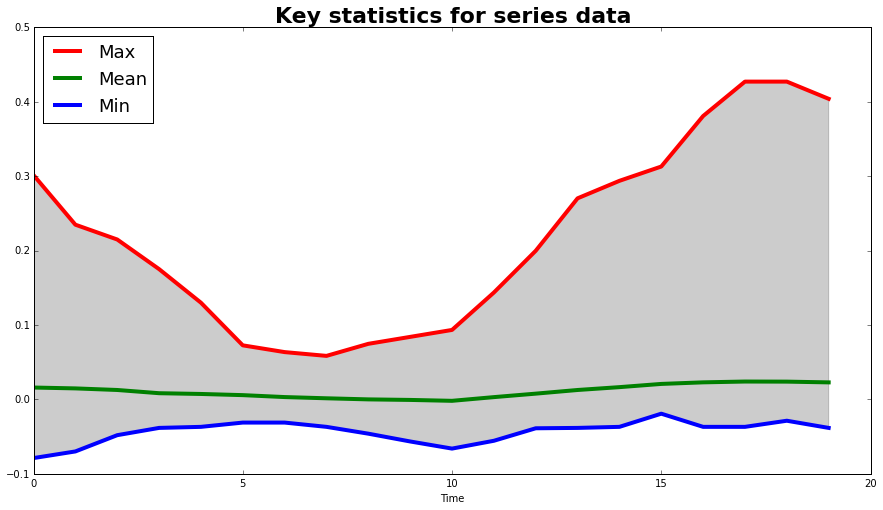

In [21]:
# Plotting
fig, ax = plt.subplots(1, figsize=(15, 8))
seriesMax_p = ax.plot(x, seriesMax, 'red', linewidth=4, label='Max');
seriesMean_p = ax.plot(x, seriesMean, 'green', linewidth=4, label='Mean');
seriesMin_p = ax.plot(x, seriesMin, 'blue', linewidth=4, label='Min');
ax.fill_between(x, np.array(seriesMin), np.array(seriesMax), alpha=0.2, color='black')
ax.legend(['Max', 'Mean', 'Min'], fontsize=18, loc=2)
plt.title('Key statistics for series data', fontsize=22, fontweight='bold')
plt.xlabel('Time')

To summarize **within records**, we can use the `map` method:

In [22]:
means = series_data.map(lambda x: x.mean())
flat_means = means.flatten().toarray()
flat_stdevs = stdevs = series_data.map(lambda x: x.std()).flatten().toarray()
print("Means:", flat_means)
print("Length of means:", len(flat_means))
print("Mean of the first series:", flat_means[0])
print("Standard deviation of the first series:", flat_stdevs[0])

Means: [ 25.8   25.85  25.7  ...,  26.    26.    26.  ]
Length of means: 13224
Mean of the first series: 25.8
Standard deviation of the first series: 0.4


`means` is now a `Series` object, where the value of each record is the mean across the time series for that voxel.

Note that in the source code above, we use function `toarray` to return all records to the driver as a numpy array.

For this `Series`, since the keys correspond to spatial coordinates, we can `pack` the results back into a local array in **driver node**.


To look at this array as an image, we can use function `draw_image` as before.

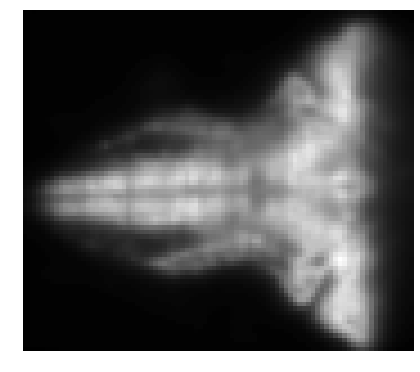

In [23]:
# we should recover the shape of means before plotting
# draw the stdandard deviations of series that belong to the first layer
draw_image(flat_means.reshape((2, 76, 87)) [0,:,:])

Note that `toarray` is an example of a local operation, meaning that all the data involved will be sent to the Spark driver node. In this case, packing the mean is no problem because its size is quite small. But for larger data sets, this can be **very problematic**. So, it's a good idea to downsample, subselect, or otherwise reduce the size of your data before attempting to pack large image data sets! 

### f. Identifying correlations

In several problem domains, it may also be beneficial to assess the similarity between a designated signal (time series) and another signal of interest by measuring their correlation. For example, say we have two time series corresponding to the consumption of Coca Cola and Pepsi, it would perhaps be interesting to verify whether behavioural patterns are similar for both brands over time.<br>

Simply as a proof of concept, we shall compare our data to a random signal and we expect that, for a random signal, the correlation should be low. The signal can be stored as a numpy array or a MAT file containing the signal as a variable. Note that the size of the signal must be equal to the size of each `Series` element.

In [24]:
from numpy import random
signal = random.randn(len(first_series))
print("The correlation of the 1st element with random signal:" , series_data.correlate(signal).first())
first_element = series_data.first()
corr = series_data.correlate(np.array(first_element)).first()
print("The correlation of the first element with itselft:", corr)

The correlation of the 1st element with random signal: [ 0.12016907]
The correlation of the first element with itselft: [ 1.]


# 3. Usecase

## 3.1. Context
Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

In this notebook,  we use K-Means, a well known clustering algorithm which is also familiar to you, as it was introduced during the last lecture on anomaly detection.

## 3.2 Data
The dataset we will use is the time series data which we played with in the previous section. Refer to section 2 if you want to duplicate the code to load such data.

## 3.3.  Building model
### a. Importing required modules

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans, KMeansModel
from matplotlib.colors import ListedColormap

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

### b. Loading & inspecting the data

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Load example series data from `fish`, then normalize and cache it to speed up repeated queries. Print the dimensional information of the loaded data.

</div>

In [26]:
# we must normalize it to get best clustering
data = td.images.fromexample('fish', engine=sc).toseries().normalize()

# Once again we want to repartition our data across our cluster
data.repartition(12)

# cache it to speed up related queries
data.cache()

# check the dimensions of data
print ('Data Shape: ', data.shape)

Data Shape:  (2, 76, 87, 20)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">
When studying the properties of large data set, we often take a small fraction of it. We have many strategies to select this subset, such as selecting randomly, selecting elements that has the standard deviation bigger than a threshold, or mixing the conditions.  

In this notebook, we will use the second method as a small demonstration.

<ul></ul>

In order to choose a good value for the threshold of standard deviation, we should compute the stddev of each series and plot a histogram of a 10% sample of the values.

<ul></ul>

Complete the source code below to compute the standard deviation of series in data. Plot the histogram of it and discuss it in details. In your opinion, what should be the best value for the threshold ?

</div>

Threshold: 0.00
Percentage of data above threshold: 57.44 %


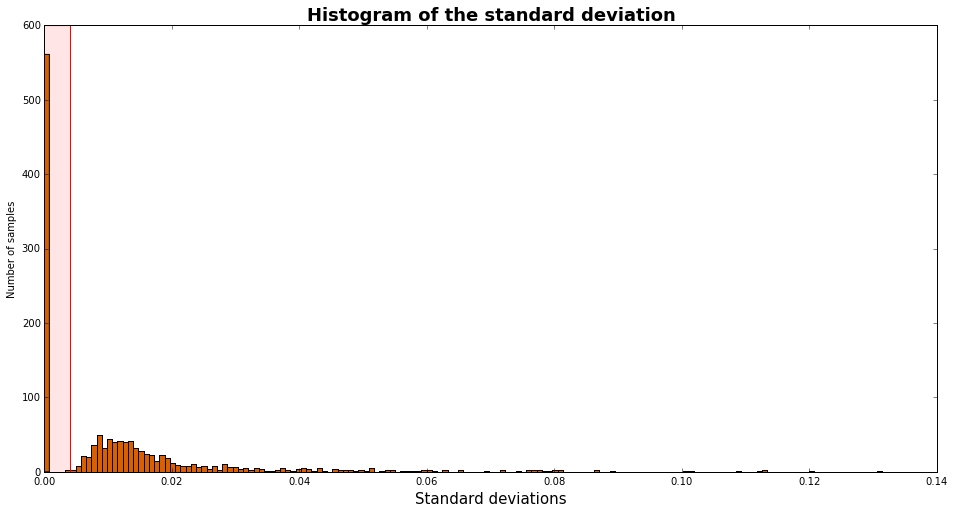

In [30]:
data_count=data.count()
# calculate the standard deviation of each series
# then select randomly 10% of value to plot the histogram
stddevs = data.map(lambda x: x.std()).sample(int(0.1*data_count))

# plot histogram of 20 bins
plt.figure(figsize=(16, 8))
plt.title('Histogram of the standard deviation', fontsize=18, fontweight='bold')
plt.hist(stddevs.toarray(), 160, color=dark2_colors[1])
plt.xlabel('Standard deviations', fontsize=15)
plt.ylabel('Number of samples')

threshold=0.004
print('Threshold: %.2f'%threshold)
plt.plot((threshold, threshold), (0, 599), 'r-')
plt.fill_between((0, threshold), 0, 599, color='red', alpha=0.1)
print("Percentage of data above threshold: %.2f %%"%float(data.filter(lambda x: x.std() >= threshold).count() / data_count *100))
plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b><br />
We can clearly set the difference between the background voxels and the active ones, and we use this difference to set the <b>threshold at 0.004</b>, filtering out everything below that value. After the filtering we still have a 57% of the voxels.<br/><br/>

We set the threshold trying to filter out the very small changes and the inmobile voxels, since they belong to the background or to completely still image (maybe the contour, but it's very unlikely to have such a small deviation), while preserving the voxels with movement, since they are the ones holding information. We decided to keep all the "movement" voxels since we don't have any extra information about the degree of noise the image has (filtering higher values could erase nois, but at the same time we could be erasing part of the important image).
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9

<div class="alert alert-info">

Extract some samples just to look at the typical structure of the time series data.
The objects are selected randomly, and has the standard deviation bigger than the threshold which you picked in question 8.
Plot the samples and discuss your obtained figure.

</div>

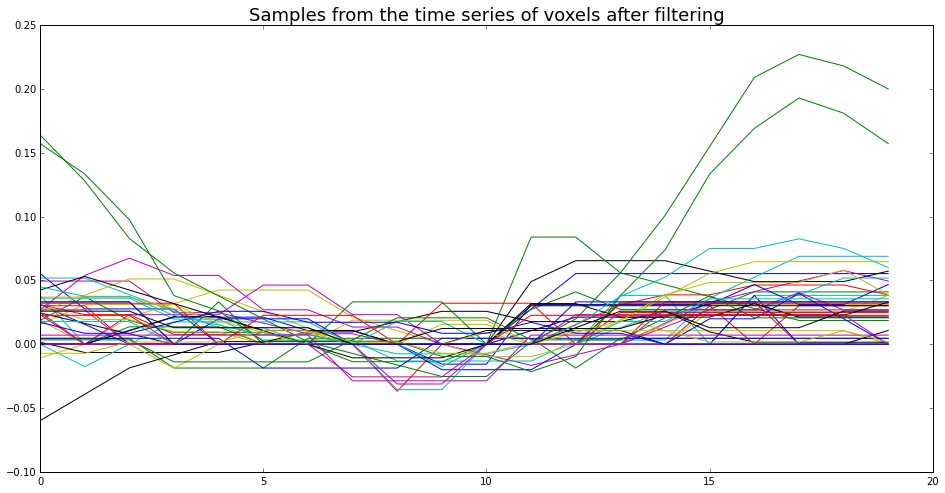

In [32]:
# sample 50 objects of the data randomly base on the standard deviation
examples = data.filter(lambda x: x.std() >= threshold).sample(50)

# plot the sample data
plt.figure(figsize=(16, 8))
plt.plot(np.array(examples).T)
plt.title('Samples from the time series of voxels after filtering', fontsize=18)
plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b><br />
Here we can already discover several voxels that behave simmilarly: the two at the top arevery active and with a similar shape, with a vast majority of mostly noise. Hopefully, what we categorize as noise now, will be split into several clusters of data after our clustering.
</div>

### c. Clustering series
In this section, we will use K-means to cluster the series. In other words, we cluster the voxels based on the their behavior. Currently, we have no clue about how many groups `K` of neural behavior. To this end, instead of choosing a single value K, we use multiple values, build model with each `K` and compare the resulting error values. After that, we can choose the best value of `K`. 

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Complete the source below to build multiple models coresponding to multiple values of `K` using algorithm KMeans of Thunder.  

a) Comment the structure of the code. Precisely, focus on the `for` loop, and state what is parallel and what is not.  

b) Can you modify the structure of the code such that you use the most of the parallelization capabilities of Spark?  

</div>

In [40]:
# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1]) ).cache()

In [41]:
# NOT COMPLETELY PARALLELIZED VERSION
# declare the possible values of K
ks = [5, 10, 15, 20, 30, 50, 100, 200]
    
def buildModels(data):
    # declare the collection of models
    models = [] 

    # build model for each K and append to models
    for k in ks:    
        models.append(KMeans.train(data, k)) 
    return models

In [44]:
import time
start = time.time()
models = buildModels(training_data)
print('Time taken to build the KMeans model without parallellizing: ',
      time.time()-start)

Time taken to build the KMeans model without parallellizing:  25.203774452209473


In [46]:
# PARALLELIZED VERSION
from sklearn.cluster import KMeans

enh_ks = sc.parallelize(ks)

def buildModelsWithParallelKMeans(data):
    bData = sc.broadcast(data.collect())
    
    models = enh_ks.map(lambda x: KMeans(x).fit(bData.value))
    
    return models.collect()

In [47]:
start = time.time()
models = buildModelsWithParallelKMeans(training_data)
print('Time taken to build the model when parallelized: ', time.time()-start)

Time taken to build the model when parallelized:  15.214370012283325


<div class="alert alert-warning">
<b>COMMENT:</b><br/>
We tried to implement sklearns implementation of KMeans in parallel and can see that this drastically reduces the computation time from 25 seconds to 15, obtaining a **40%** reduction. From now on, we will only use the parallellized version.

a) The parallelisation comes from using Kmeans from Mllib Spark, meaning that the KMeans training is done in parallel (all the process inside the call to `models.append(KMeans.train(data, k))`). However, each iteration on this for loop (iterating `k in ks`) is not parallelized.

 b) It's as simple as using the KMeans from sklearn and parallellize it, while using a map function (parallelizable) to fit the models. We need as well a broadcast variable for the data, and finally we collect all the results.
</div>

### d. Testing models & choosing the best one

Next, we evaluate the quality of each model. We use two different error metrics on each of the clusterings. 

* The first is the sum across all time series of the Euclidean distance from the time series to their cluster centroids. 

* The second is a built-in metric of the `KMeansModel` object.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11

<div class="alert alert-info">  

a) Write function `model_error_1` to calculate the sum of Squared Euclidean Distance from the Series objects to their clusters centroids.  

b) Comment the choice of the error function we use here. Is it a good error definition?

</div>

In [48]:

from scipy.spatial.distance import cdist

# calculate the Euclidean distance
# from each time series to its cluster center
# and sum all distances
def model_error_1(data, model):
    
    bModel = sc.broadcast(model)
    #t = np.asarray(data.map(lambda x: cdist([x], [bModel.value.cluster_centers_[bModel.value.predict(x)]], metric='sqeuclidean')))
    #print(t.collect())
    #return t
    return data.map(lambda x: np.linalg.norm(x - bModel.value.cluster_centers_[bModel.value.predict(x)])**2).reduce(lambda x,y: x+y)
    
    #errors = data.map(lambda x: cdist([x], [model.centers[model.predict(x)]], metric='sqeuclidean'))
    #return errors.sum()[0][0]

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
The problem with using Euclidean Distance for time series is that it includes the mean error in the calculations, which would force two signals with the same shape but with a different average to be treated differently:
<br/><br/>
**EXAMPLE**<br/>
signal1=sin(w*t)<br/>
signal2=1000+signal1<br/>
signal3=1000<br/>
In this case, the shapes of signal1 and signal2 are very similar except for the mean of the series, but a KMeans clustering model based on Euclidean distance with K=2 would set signal2 alongside signal3.<br/><br/>
Probably a best error measurement should include correlation rather than Euclidean distances.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

a) Write function `model_error_2` to calculate the total of similarity of `Series` objects based on how well they match the cluster they belong to, and then calculate the error by inverse the total similarity.  

b) Similarly to the previous question, comment the choice of the similarity function.  

</div>

In [49]:

# calculate the total of similarity of the model on timeseries objects
# and calculate the error by inverse the total similarity

# Estimate similarity between a data point and the cluster it belongs to.
def similarity(centers, p):
    if np.std(p) == 0:
        return 0
    return np.corrcoef(centers[np.argmin(cdist(centers, np.array([p])))], p)[0, 1]


def model_error_2(data, model):
    ## Start extension
    bCenters = sc.broadcast(model.cluster_centers_)
    return 1. / data.map(lambda x: similarity(bCenters.value, x)).reduce(lambda x, y: x + y)
    ## End extension
    #return 1. / data.map(lambda x: similarity(model.centers, x)).reduce(lambda x, y: x + y)


<div class="alert alert-warning">
<b>COMMENT:</b><br/>
On this case we're using the correlation between time series to determine the error, which should yield a much better result as explained on the previous section. Time series are similar to each other based on their correlation coefficients. Another example would be to have a time series n-shifted in time: this would yield a high euclidean distance, but the correlation coefficients corresponding to the nth element wrt each element would be very high, showing the high degree of similarity between the original and the shifted signal
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Plot the error of the models along with the different values of K in term of different error metrics above. From the figure, in your opinion, what is the best value for `K` ? Why ?

</div>

In [51]:
def testAndPlotTheResult(data, models):
    # compute the error metrics for the different resulting clusterings
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_1(data, model) for model in models])
    
    # error of models when using similarity
    errors_2 = np.asarray([model_error_2(data, model) for model in models])

    # plot the errors with each value of K
    plt.figure(figsize=(15, 8))
    plt.ylabel('Error')
    plt.xlabel('K - Number of clusters')
    # Plot and add labels
    # Remove collect() if no parallelization
    plt.plot(enh_ks.collect(), errors_1 / errors_1.sum(), 'k-o', label='Model 1', linewidth=4)
    plt.plot(enh_ks.collect(), errors_2 / errors_2.sum(), 'b:v', label='Model 2', linewidth=4)
    plt.legend(loc='upper right')
    
    plt.xticks(np.arange(0, 200, 10.0))
    plt.show()

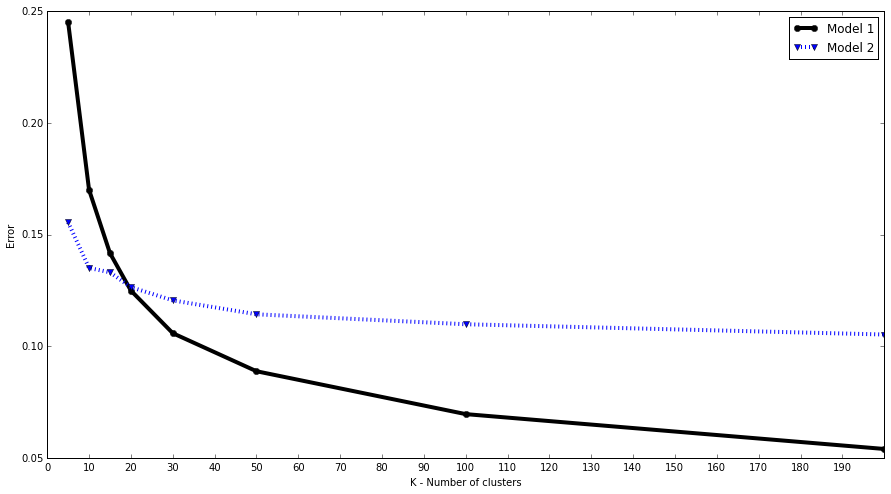

In [52]:
testAndPlotTheResult(training_data, models)

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
The models based on the **euclidean distance** are constantly improving in the accuracy as expected, since the more centroids there are, the less error it will be -> [Proof of convergence](http://math.mit.edu/~rothvoss/18.304.1PM/Presentations/1-Yihui-Talk1.pdf)This makes it very difficult for us to choose a good value for K, which adds up an extra problem to those already mentioned previously about using Euclidean Distance.<br/><br/>
On the other side, we see that the models based on **similarity**(correlation between signals) start stabalizing around K=30, and remain more stable in absolute value than the models with euclidean distance. 

</div>

Determining the optimal $k$ is particularly troublesome for the $k$-Means algorithm because error measures based on distance decrease monotonically as $k$ increases. This arises because when $k$ is increased, each cluster is decomposed into more and more clusters, such that each point becomes closer to its cluster mean. In fact, in the extreme case where $k=N$, each point will be assigned to its own cluster, and all distances are reduced to nil. Cross-validation or using holdout data is also unlikely to be particularly effective in this case.<br>

To this end, it is often worth assessing a model by measuring its impact on the overall aim of carrying out the clustering. For example, if we are carrying out $k$-means for grouping customers having similar taste and purchase history with the ultimate intent of making recommendations to customers, our objective function should measure how effective the recommendations are (perhaps using holdout data). An appealing aspect of using such a metric is that it is no longer guaranteed to behave monotonically with respect to $k$. We shall investigate this further in Question 20.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Plot the centroids of the best model. Do you think that the result is good ?

</div>

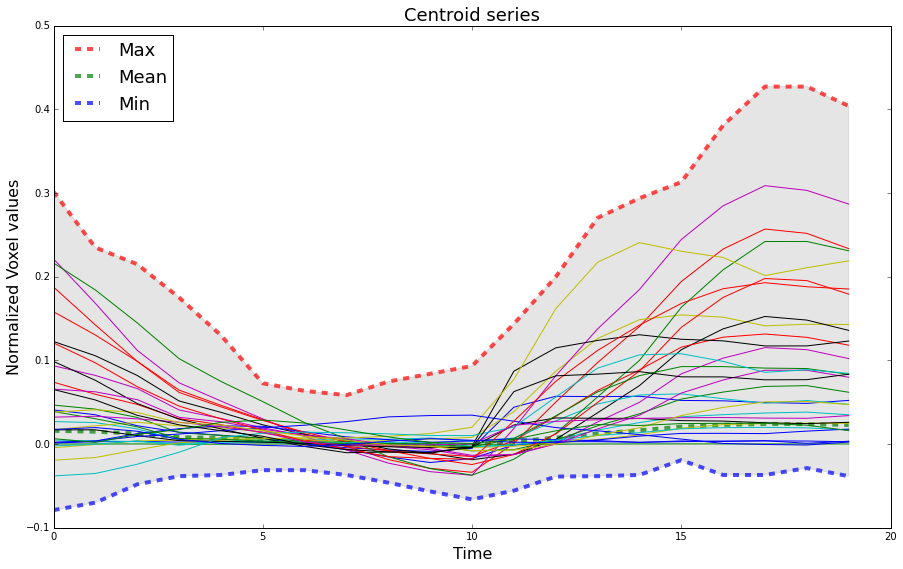

In [68]:
# plot the chosen model -> model 5 with K=30
bestModel = models[4]

fig, ax = plt.subplots(1,1, figsize=(15, 9))

# Plot descriptive values
seriesMax_p = ax.plot(x, seriesMax, 'red', linewidth=4, label='Max', alpha=0.7, linestyle='--');
seriesMean_p = ax.plot(x, seriesMean, 'green', linewidth=4, label='Mean', alpha=0.7, linestyle='--');
seriesMin_p = ax.plot(x, seriesMin, 'blue', linewidth=4, label='Min', alpha=0.7, linestyle='--');
ax.fill_between(x, np.array(seriesMin), np.array(seriesMax), alpha=0.1, color='black')
ax.legend(['Max', 'Mean', 'Min'], fontsize=18, loc=2)

# Plot Centroids
ax.plot(np.asarray(bestModel.cluster_centers_).T)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Normalized Voxel values', fontsize=16)
ax.set_title('Centroid series', fontsize=18)

plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
In order to determine wether the result is good or not we are answering two questions:
<ol>
<li>**Are the centroids evenly distributed?** They seem to be quite concentrated arround time 5 to 10, but in the rest of frames they appear to be fairly distributed, with different signal shapes and amplitudes. **YES**</li>
<li>**Do the centroids cover the whole space of time series?** In order to answer this wuestion, we've opted for plotting in the background previous info about the maximum, minimum and average of the time series. Thanks to it we can see that they more or less cover the whole space except for a small margin to the maximum and minimum, which is understandable since both maximum and minimum come from potential outliers. **YES**</li>
</ol>
</div>

### e. Visualizing the result
We can also plot an image of labels of neurons, such that we can visualize the group of each neuron.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 15

<div class="alert alert-info">

Complete the source code below to visualize the result of clustering.

</div>

In [69]:
# predict the nearest cluster id for each voxel in Series
#labels = bestModel.predict(training_data)
labels = training_data.map(lambda x: bestModel.predict(x))

In [70]:
# collect data to the driver
imgLabels = np.asarray(labels.collect()).reshape((2, 76, 87))
print(imgLabels)

[[[ 7  1 29 ...,  1  1  1]
  [ 1  1  1 ...,  1  1  1]
  [ 1  1  1 ...,  1  7  1]
  ..., 
  [ 1  1  1 ...,  1  1  1]
  [ 7  1  1 ...,  7  1  1]
  [ 1  1 29 ...,  1  1  1]]

 [[ 1  1  1 ...,  1  1  1]
  [ 1  1  1 ...,  1  1  1]
  [ 1  1  1 ...,  1  1  1]
  ..., 
  [ 1  1  1 ...,  1  1  1]
  [ 1  1  1 ...,  1  1  1]
  [ 1  1  1 ...,  1  1  1]]]


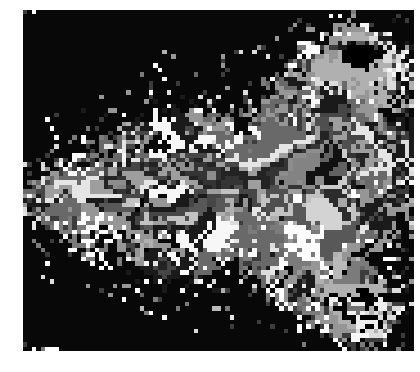

In [71]:
# consider the voxel of the first layers
draw_image(imgLabels[0,:,:])

With the default color scheme, this figure is quite difficult to understand and to distinguish the groups according to their similar colors. So, we should have a smater color selection. The fact is, when we do clustering, it is often the case that some centers are more similar to one another, and it can be easier to interpret the results if the colors are choosen based on these relative similarities. The method `optimize` tries to find a set of colors such that similaries among colors match similarities among an input array (in this case, the cluster centers). The optimization is non-unique, so you can run multiple times to generate different color schemes.

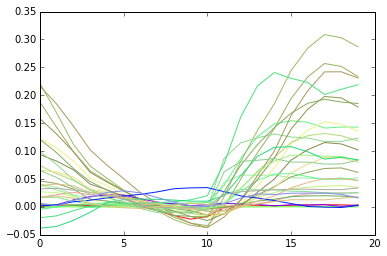

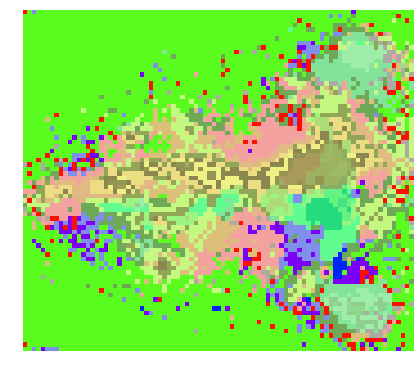

In [84]:
from numpy import arctan2, sqrt, pi, abs, dstack, clip, transpose, inf, \
    random, zeros, ones, asarray, corrcoef, allclose, maximum, add, multiply, \
    nan_to_num, copy, ndarray, around, ceil, rollaxis

# these functions below are inspired mainly from Thunder-Project source code, v.0.6
# url: https://raw.githubusercontent.com/thunder-project/thunder/branch-0.6/thunder/viz/colorize.py

# Optimal colors based on array data similarity.
def optimize_color(mat):
        mat = np.asarray(mat)

        if mat.ndim < 2:
            raise Exception('Input array must be two-dimensional')

        nclrs = mat.shape[0]

        from scipy.spatial.distance import pdist, squareform
        from scipy.optimize import minimize

        distMat = squareform(pdist(mat, metric='cosine')).flatten()

        optFunc = lambda x: 1 - np.corrcoef(distMat, squareform(pdist(x.reshape(nclrs, 3), 'cosine')).flatten())[0, 1]
        init = random.rand(nclrs*3)
        bounds = [(0, 1) for _ in range(0, nclrs * 3)]
        res = minimize(optFunc, init, bounds=bounds, method='L-BFGS-B')
        newClrs = res.x.reshape(nclrs, 3).tolist()

        from matplotlib.colors import ListedColormap

        newClrs = ListedColormap(newClrs, name='from_list')

        return newClrs

# Blend two images together using the specified operator.
def blend(img, mask, op=add):
        if mask.ndim == 3:
            for i in range(0, 3):
                img[:, :, :, i] = op(img[:, :, :, i], mask)
        else:
            for i in range(0, 3):
                img[:, :, i] = op(img[:, :, i], mask)
        return img

def _prepareMask(mask):
        mask = asarray(mask)
        mask = clip(mask, 0, inf)

        return mask / mask.max()
    
# Colorize numerical image data.
def transform(cmap, img, mask=None, mixing=1.0):
        from matplotlib.cm import get_cmap
        from matplotlib.colors import ListedColormap, LinearSegmentedColormap, hsv_to_rgb, Normalize

        img = asarray(img)
        dims = img.shape

        if cmap not in ['polar', 'angle']:

            if cmap in ['rgb', 'hv', 'hsv', 'indexed']:
                img = copy(img)
                for i, im in enumerate(img):
                    norm = Normalize(vmin=None, vmax=None, clip=True)
                    img[i] = norm(im)

            if isinstance(cmap, ListedColormap) or isinstance(cmap, str):
                norm = Normalize(vmin=None, vmax=None, clip=True)
                img = norm(copy(img))

        if mask is not None:
            mask = _prepareMask(mask)

        if isinstance(cmap, ListedColormap):
            if img.ndim == 3:
                out = cmap(img)
                out = out[:, :, :, 0:3]
            if img.ndim == 2:
                out = cmap(img)
                out = out[:, :, 0:3]
        else:
            raise Exception('Colorization method not understood')

        out = clip(out, 0, 1)

        if mask is not None:
            out = blend(out, mask, multiply)

        return clip(out, 0, 1)


# generate the better color scheme
#newClrs = optimize_color(bestModel.centers)
newClrs = optimize_color(bestModel.cluster_centers_)

plt.gca().set_color_cycle(newClrs.colors)
#plt.plot(np.array(bestModel.centers).T);
plt.plot(np.array(bestModel.cluster_centers_).T)

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap)


### f. Improving the result by removing noise
One problem with what we've done so far is that clustering was performed on all time-series without data pre-processing. Many of  time-series objects were purely noise (e.g. those outside the brain), and some of the resulting clusters capture these noise signals. A simple trick is to perform clustering after subselecting pixels based on the standard deviation of their time series. First, let's look at a map of the standard deviation, to find a reasonable threshold that preserves most of the relavant signal, but ignores the noise.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 16

<div class="alert alert-info">

Try with different threshold of standard deviation to filter the noise. What is the "best value" that preserves most of the relavant signal, but ignores the noise ? Why ?

</div>

In [110]:
# calculate the standard deviation of each voxel 
# then collect to the driver
stdMap = data.map(lambda x: x.std()).toarray()

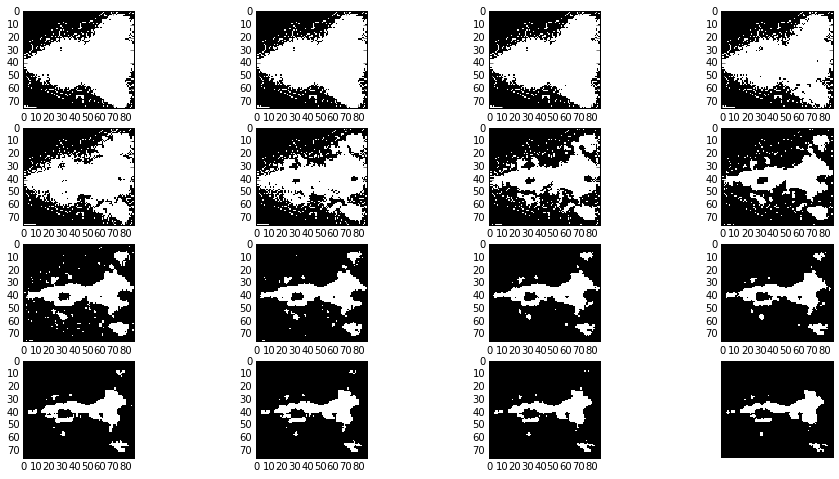

In [187]:
# Trying several thresholds
fig, axarr = plt.subplots(4,4, figsize=(16, 8))
range_ = np.arange(0.001, 0.032, 0.002)
axe = [[i, j] for i in range(0,4) for j in range(0,4)]
for x, i in enumerate(range_):
  draw_image(stdMap[0,:,:] > i, ax=axarr[axe[x][0], axe[x][1]])

In [ ]:
# here we should try with many different values of threshold 
# and choosing the best one
# visualize the map of the standard deviation after filtering
threshold = 0.020

Threshold: 0.020
Percentage of data above threshold: 17.39 %


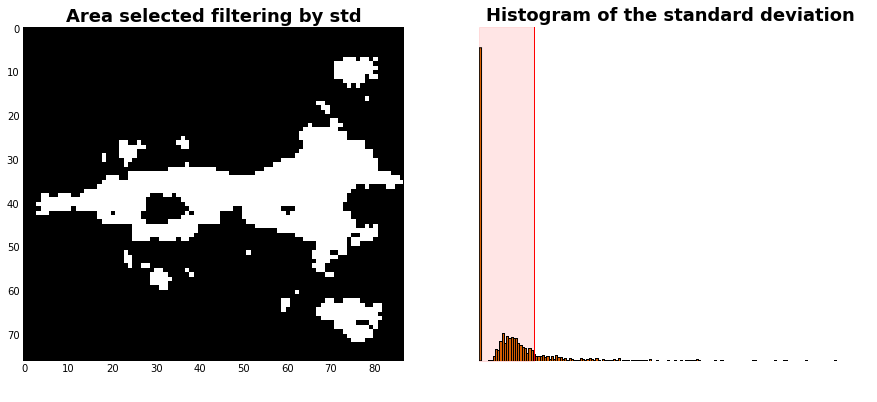

In [113]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

draw_image(stdMap[0,:,:] > threshold, ax=ax1)
ax1.set_title('Area selected filtering by std', fontsize=18, fontweight='bold')
# plot histogram of 20 bins
ax2.set_title('Histogram of the standard deviation', fontsize=18, fontweight='bold')
ax2.hist(stddevs.toarray(), 160, color=dark2_colors[1])
ax2.set_xlabel('Standard deviations', fontsize=15)
ax2.set_ylabel('Number of samples')

print('Threshold: %.3f'%threshold)
ax2.plot((threshold, threshold), (0, 599), 'r-')
ax2.fill_between((0, threshold), 0, 599, color='red', alpha=0.1)
print("Percentage of data above threshold: %.2f %%"%float(data.filter(lambda x: x.std() >= threshold).count() / data_count *100))
plt.show()


<div class="alert alert-warning">
<b>COMMENT</b>:<br/>
We have duplicated our section on the threshold histogram from before, since the combined information of both plots can help us to better select the threshold. In order to select the threshold we tried all values between 0.001 and 0.03 with a step of 0.001. We found 0.02 to be the threshold that filters out most of the noise while preserving the crucial areas of the image where the most changes occur. If we see this in the histogram, after the peak of constant voxels and a mountain of noise there is a plateau of values that could holdvaluable information. Both plots are consistent in their results. Therefore, our new **threshold is 0.02**, which leaves us a 17% of the voxels from the image.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 17

<div class="alert alert-info">

Filter your data such that we only keep the voxels that have the standard deviation bigger than the threshold in question 16.

</div>

In [119]:
####!@SOLUTION@!####
from numpy import std
# remove series object that has the standard deviation bigger than a threshold
filtered = data.filter(lambda x: x.std() > threshold).cache()
print(filtered.shape)


(2299, 20)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 18

<div class="alert alert-info">

Re-train and choose the best models with different values of `K` on the new data.

</div>

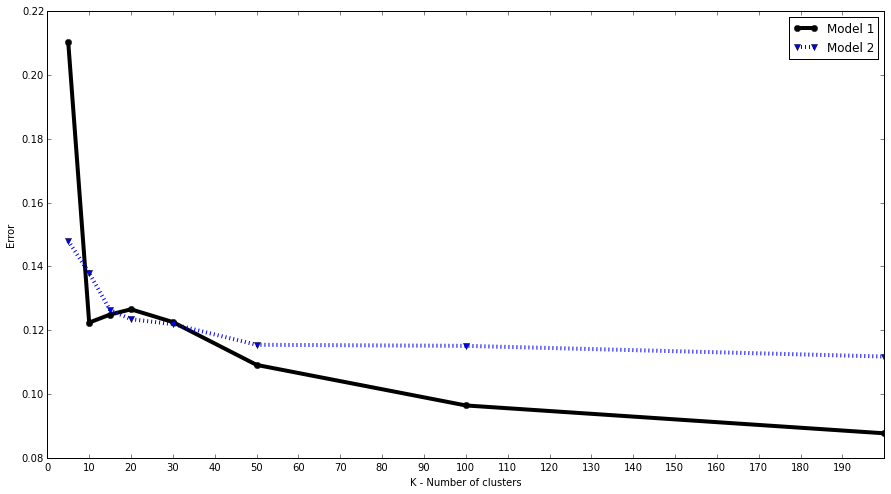

In [120]:
models = buildModelsWithParallelKMeans(filtered.tordd().map(lambda x: np.array(x[1])).cache())
testAndPlotTheResult(training_data, models)

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
Similar to the one obtained beforehand, we se how the Euclidean Distance is smoothly decreasing with K, while the similarity models have a natural limit (almost no gain from then on) in K=50. We'll use K=20 with the similarity error measurement, which means using the model 4 (models[3]), because it shows a very small decrease in similarity from that point on and ath the cost of a higher number of clusters

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 19
<div class="alert alert-info">

a) Plot the centroids of the best model with a smart color selection.  

b) Plot the result of the clustering algorithm by a color map of voxels.  

c) Comment about your figures.  
</div>

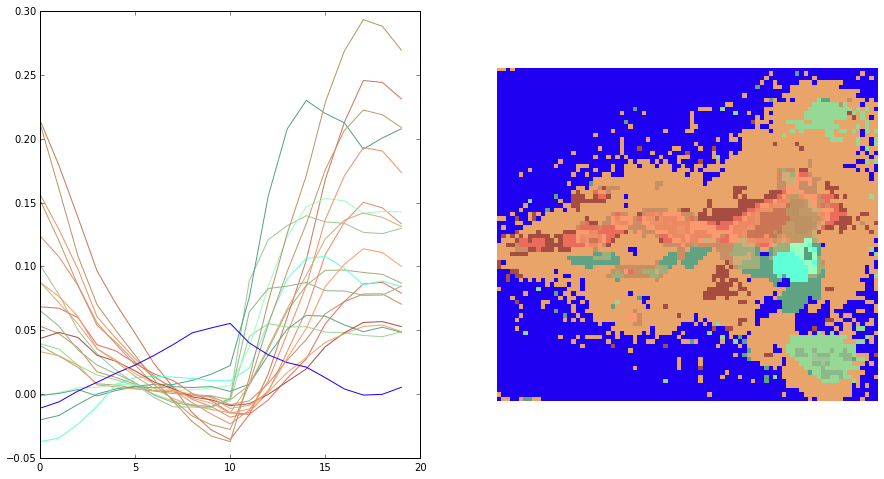

In [128]:
# Using the chosen model: K=20 -> model 4 -> models[3]
bestModel = models[3]

newClrs = optimize_color(bestModel.cluster_centers_)

fig, axarr = plt.subplots(1,2, figsize=(15,8))
axarr[0].set_color_cycle(newClrs.colors)
axarr[0].plot(np.array(bestModel.cluster_centers_).T)

# predict the nearest cluster id for each voxel in Series
labels = data.map(lambda x: bestModel.predict(x))
#labels = bestModel.predict(training_data)

# collect data to the driver
imgLabels = labels.toarray().reshape((2, 76, 87))

brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap, ax=axarr[1])


<div class="alert alert-warning">
<b>COMMENT</b><br/>
We see how our image can be correctly classified with K=20, using one class for the background (blue) and one for the most neutral/passive regions of the brain (light brown), while showing two different active behaviours in the brown-redish areas and in the blueish areas. We still have some noise, but most of the noise is comprised inside the neutral/passive cluster, leaving us with a much cleaner image if we leave out this cluster from our consideration when analyzing the image

</div>

### g. Improve the visualization by adding similarity
These maps are slightly odd because pixels that did not survive our threshold still end up colored as something. A useful trick is masking pixels based on how well they match the cluster they belong to. We can compute this using the `similarity` method of `KMeansModel`.

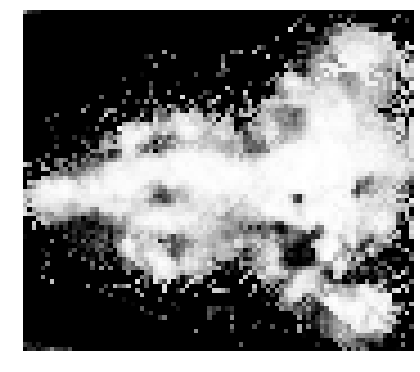

In [130]:
sim = data.map(lambda x: similarity(bestModel.cluster_centers_, x))

imgSim = sim.toarray()

# draw the mask
draw_image(imgSim[0,:,:], cmap='gray', clim=(0,1))

And, it can be used as a linear mask on the colorization output

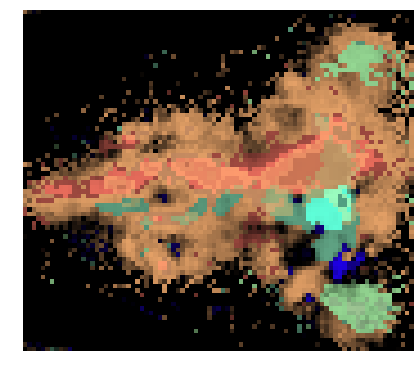

In [131]:
brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[0,:,:])
draw_image(brainmap)

<div class='alert alert-warning'>
<b>COMMENT:</b><br>
As we can see in the image, he colours selected are very similar to those in the previous image, with a brown area mostly with passive regions, a redish area with activity and a light blue area with a different but also noticeable activity.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 20

<div class="alert alert-info">

Since in the usecase we build and test the model from the same data, it can lead to overfitting problems. To avoid that, we can divide the data into training set and testing set. Note that each neuron occurs only one time in the data. So, we can not divide the data by dividing the neurons. Instead, we can divide the states of neurons into two different sets. Let's try with this approach and show the result.

</div>

In [198]:
def split(data, threshold, data_set):
    return (data.tordd()
                 .map(lambda x: np.array(x[1]))
                 .filter(lambda x: x.std() > threshold)
                 .map(lambda x: np.array([n for i, n in enumerate(x) if i in data_set]))
                 .cache())

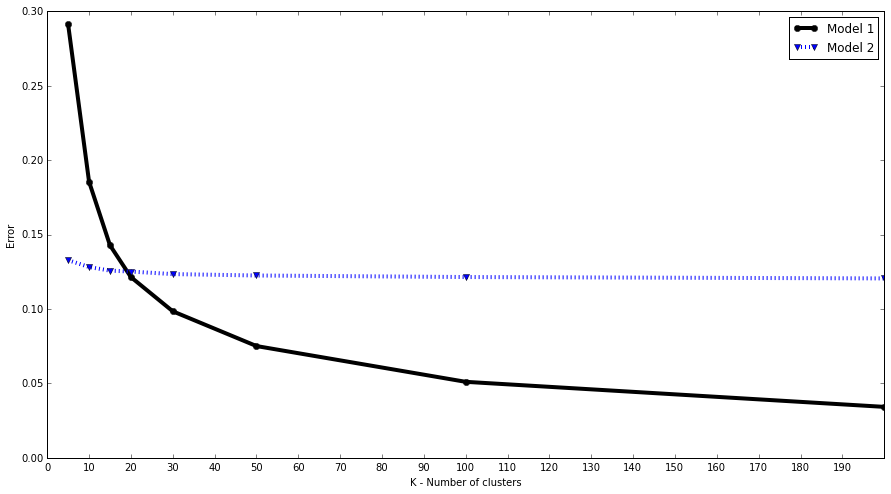

In [201]:
### Divide the data
# Create array of 20 "layers"
indx = np.arange(20)
np.random.shuffle(indx)
train_indx, test_indx = indx[:-10], indx[10:]

# Now, lets split the data into two sets
training_data = split(data, threshold, train_indx)

# Lets build our two models!
training_models = buildModelsWithParallelKMeans(training_data)

# Plot the two results of our models
testAndPlotTheResult(training_data, training_models)

<div class='alert alert-warning'>
<b>COMMENT:</b><br/>
Based on the flatness of the similarity curve, we are going to use K=10 for the clustering. Next thing to do is to apply the model to the test data and see how it works (we'll be showing only the result in one image). We splitted the data in two in order to have 50% for training and 50% for testing.</div>

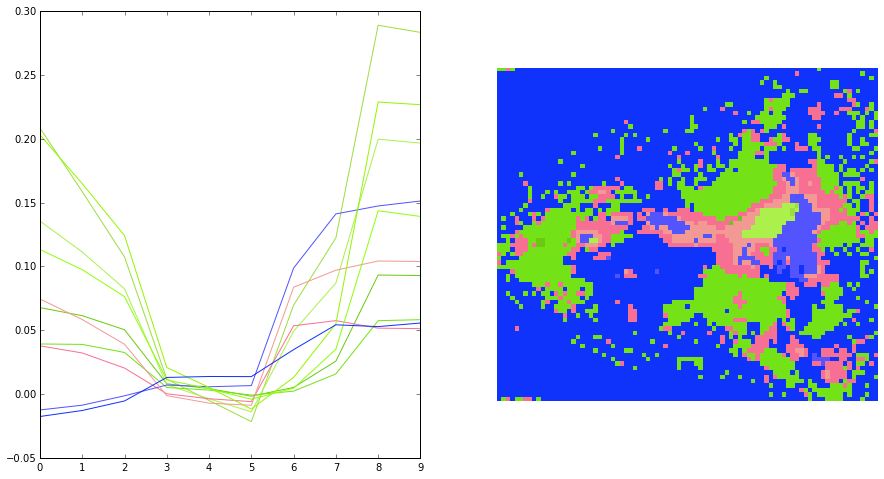

In [203]:
test_data = (data.map(lambda x: np.array([n for i, n in enumerate(x) if i in test_indx])).cache())

# Using the chosen model: K=20 -> model 4 -> models[3]
bestModel = training_models[1]

newClrs = optimize_color(bestModel.cluster_centers_)

fig, axarr = plt.subplots(1,2, figsize=(15,8))
axarr[0].set_color_cycle(newClrs.colors)
axarr[0].plot(np.array(bestModel.cluster_centers_).T)

# predict the nearest cluster id for each voxel in Series
labels = test_data.map(lambda x: bestModel.predict(x))
#labels = bestModel.predict(training_data)

# collect data to the driver
imgLabels = labels.toarray().reshape((2, 76, 87))

brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap, ax=axarr[1])

<div class='alert alert-warning'>
<b>COMMENT:</b><br/>
With less data and less clusters, we should be expecting the result we obtained: much more noisy voxels in the space domain, translated into less accurate clustering. A second approach would be to use a LOO testing (Leave one out), using all but one frame for the clustering, then adding the extra cluster and measuring the prediction accuracy, averaging throught the whole dataset. <br/><br/>
A more advanced suggestion would be to featurize the image similarly CNNs, applying convolutional layers with depth in time in order to better understand the concept of'active region', then use those features for the clustering with the methods used here.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 21

<div class="alert alert-info">

Is using K-Means the best choice for a clustering algorithm? Comment the choice and suggest alternatives. For example, look at [Mixture Models](https://en.wikipedia.org/wiki/Mixture_model) and, if you have time, propose an alternative clustering technique. 

</div>

<div class="label label-danger">NOTE</div> Mixture models will be covered in the ASI course in greater detail.

In [188]:
from sklearn.mixture import GMM

In [189]:
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()

([<matplotlib.image.AxesImage at 0x7f2b302aa940>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f2b34cb5860>)

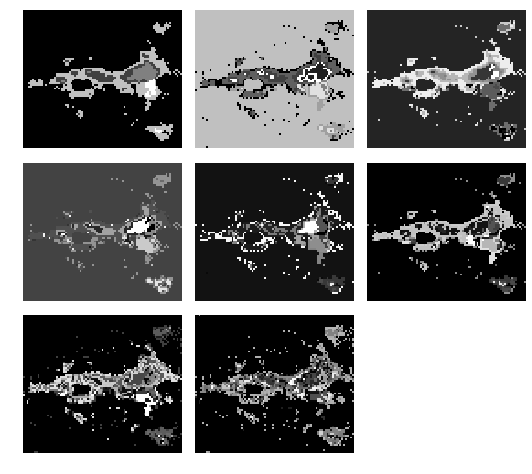

In [191]:
images = []
for k in enh_ks.collect():
    gaussianMixtureModel = GMM(k)
    gaussianMixtureModel.fit(training_data.collect())
    labels = data.map(lambda x: gaussianMixtureModel.predict(x))
    imgLabels = labels.toarray().reshape(2, 76, 87)
    images.append(imgLabels[0, :, :])

# Draw all images in a grid
draw_tile(images)

<div class="alert alert-warning">
<b>COMMENT:</b><br />
We implemented the GaussianMixtureModel from sklearn but did not have the time to compare it to our KMeans implementation.     
We wanted to try GMM since it chooses which center a point is dedicated to. For KMeans we choose the cluster a point belongs to by taking the closes center (an easy approach). For GMM the points adapts to the density, so the choice of a center is based on who is closest and the associated gaussian. 
</div>

# 4. Summary
We studied Thunder and its important methods to work with images, such as `Image`, `Series` and how to apply them to a use case. In the use case, we used the K-Means algorithm to cluster the neurons without prior knowledge of what a good choice of K could be. Subsequently, we introduced some techniques for improving the initially obtained results, such as removing noise and considering similarity.

# References
Some of the examples in this notebook are inspired from the [documentation of Thunder](http://docs.thunder-project.org/).